In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner

from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde, TransformBoundedKDE
from pesummary.gw.plots.bounds import default_bounds
from scipy import stats

import tensorflow as tf
import tensorflow_probability as tfp
import gpflow
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from uncertainties import unumpy

from gp4gw.density.bounded_model import BoundedDensityModel
from gp4gw.density.data_preparation import *
from gp4gw.density.training_tools import *

# import scipy.integrate as integrate
from scipy import interpolate

In [2]:
%matplotlib inline

In [3]:
np.random.seed(103543)

# Loading posterior samples and selecting 2 dimensions to interpolate, e.g. sky location parameters

In [4]:
data_path = "~/GP-density-estimation/pe_samples/GW150914_downsampled_posterior_samples.dat"

In [5]:
unscaled_data = pd.read_csv(data_path).sample(frac=1)
print("Posterior samples array: ", unscaled_data.shape)

Posterior samples array:  (50000, 42)


In [6]:
param_names = ["ra", "dec"]

# Select optimal binning

We bin the data such that w have a few empty bins where the probability is zero

In [7]:
Nb = 30
bin_array = np.vstack(
    [
        np.linspace(
            unscaled_data["ra"].min() - 0.1, unscaled_data["ra"].max() + 0.1, Nb
        ),
        np.linspace(
            unscaled_data["dec"].min() - 0.1, unscaled_data["dec"].max() + 0.1, Nb
        ),
    ]
)

# Setting up histogram and scale data

The posterior (log_likelihood + log_prior) is defined over all parameters (~15D). 

We want to interpolate only over a slice (say 2D), i.e. the marginal posterior, which we can approximate as the value of bin counts in the 2D histogram.

In [8]:
counts, bins = np.histogramdd(
    np.array(unscaled_data[param_names]), density=True, bins=bin_array
)

In [9]:
x = create_2d_data_set(bins)
y = counts.flatten()

Shape of binning: (29, 2)
Histogram points: (841, 2)


In [10]:
x_scaled, y_scaled, x_scaler, y_scaler = scale_data(x, y)

X = tf.convert_to_tensor(x_scaled, dtype=tf.float64)
Y = tf.convert_to_tensor(y_scaled.reshape(-1, 1), dtype=tf.float64)

Shape of x-data: N=841, Q=2


In [11]:
prior_ranges = {
    "ra": tfp.distributions.Uniform(
        unscaled_data["ra"].min(), unscaled_data["ra"].max()
    ),
    "dec": tfp.distributions.Uniform(
        unscaled_data["dec"].min(), unscaled_data["dec"].max()
    ),
}

# Setup GP model
* add noise error from histogram to the GP likelihood
* define kernel

In [12]:
dens_std, dens_std_unscaled = calc_hist_errors(np.array(unscaled_data[param_names]), bin_array, y_scaler)

In [13]:
dens_std_1 = dens_std + 1.1 * 10 ** - 6  # adding some jitter to avoid Cholesky decomposition errors

In [14]:
var = dens_std_1 ** 2

In [15]:
Y_data = np.hstack([Y, tf.reshape(var, (-1, 1))])

In [16]:
likelihood = HeteroskedasticGaussian()

In [17]:
k1 = gpflow.kernels.RBF(lengthscales=[0.1] * len(param_names), variance=1.0)
k4 = gpflow.kernels.Matern12(lengthscales=[0.05] * len(param_names), variance=0.1)


kernel = k1 * k4

In [18]:
model = gpflow.models.VGP(
    (X, Y_data),
    kernel=kernel,
    likelihood=likelihood,
    num_latent_gps=1,
    mean_function=gpflow.mean_functions.Constant(y_scaler.transform(np.zeros((1, 1)))),  # we set the mean GP to be zero probability dnsity
)

# Build GP model

In [19]:
natgrad = gpflow.optimizers.NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam()

Epoch 10: LOSS (train) 2477114.0911555374
CPU times: user 45.2 s, sys: 7 s, total: 52.2 s
Wall time: 6.31 s


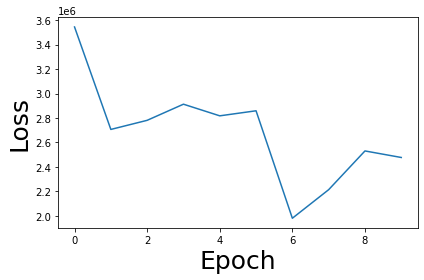

In [20]:
%%time
train_exact_heteroskedastic(model, adam, natgrad, 10)

In [21]:
print(
    f"Training error: {mean_squared_error(Y, model.predict_f(X)[0])}"  # , Testing error: {mean_squared_error(Y_test, model.predict_y(X_test)[0])}"
)

Training error: 0.027077731340954602


In [22]:
bounded_model = BoundedDensityModel(
    likelihood=model.predict_f,
    param_names=param_names,
    priors=prior_ranges,
    parameters_scaler=x_scaler,
    y_scaler=y_scaler,
)

# Evaluate 50% 90% and 99% contour lines for plotting 2D model
* The contour lines are calculated for the GP mean and for the 2-sigma error bands
* To evaluate the contours we evaluate the GP model over a grid of points

In [23]:
bin_grid = x_scaler.transform(create_2d_data_set(bin_array))

Shape of binning: (29, 2)
Histogram points: (841, 2)


In [24]:
sigmas = 2 # change here if you want different error bands

In [25]:
# Evaluating the bounded model in "scaled" space
mean, var = bounded_model.predict(bin_grid)

In [26]:
bin_shape = Nb - 1

In [27]:
z_high = y_scaler.inverse_transform(mean + sigmas*np.sqrt(var))
z_high = z_high.reshape(bin_shape, bin_shape)
z_high = z_high / z_high.sum()

z_low = y_scaler.inverse_transform(mean - sigmas*np.sqrt(var))
z_low = z_low.reshape(bin_shape, bin_shape, order="C")
z_low = z_low / z_low.sum()

z = y_scaler.inverse_transform(mean)
z = z.reshape(bin_shape, bin_shape, order="C")
z = z / z.sum()

n = 1000
t = np.linspace(0, z.max(), n)
t_high = np.linspace(0, z_high.max(), n)
t_low = np.linspace(0, z_low.max(), n)

integral = ((z >= t[:, None, None]) * z).sum(axis=(1, 2))
f = interpolate.interp1d(integral, t)

integral_high = ((z_high >= t_high[:, None, None]) * z_high).sum(axis=(1, 2))
f_high = interpolate.interp1d(integral_high, t_high)

integral_low = ((z_low >= t_low[:, None, None]) * z_low).sum(axis=(1, 2))
f_low = interpolate.interp1d(integral, t_low)

t_contours = f(np.array([0.99, 0.90, 0.5]))
t_contours_high = f_high(np.array([0.99, 0.90, 0.5]))
t_contours_low = f_low(np.array([0.99, 0.90, 0.5]))

# Marginalise GP model mean and uncertainty over ra and dec

* To propagate the errors from "scaled" space to "real" space we use the uncertainty package
* The marginals are then normalised to be a density: Density counts = N_counts / Volume

In [28]:
mean = mean.reshape(bin_shape, bin_shape, order="C")
gp_var = var.reshape(bin_shape, bin_shape, order="C")

In [29]:
mean_ra = np.mean(mean, axis=1)
mean_dec = np.mean(mean, axis=0)

In [30]:
std_ra = np.sqrt(np.mean(gp_var, axis=1))
std_dec = np.sqrt(np.mean(gp_var, axis=1))

In [31]:
sum_with_error_ra = unumpy.uarray(mean_ra, std_ra)
sum_with_error_dec = unumpy.uarray(mean_dec, std_dec)

In [32]:
scaled_sum_with_error_ra = sum_with_error_ra * y_scaler.scale_
scaled_sum_with_error_ra = scaled_sum_with_error_ra + y_scaler.mean_

scaled_sum_with_error_dec = sum_with_error_dec * y_scaler.scale_
scaled_sum_with_error_dec = scaled_sum_with_error_dec + y_scaler.mean_

In [33]:
# Normalise so that it is a density
scaled_dens_with_error_ra = (
    scaled_sum_with_error_ra
    * 1
    / (unumpy.nominal_values(scaled_sum_with_error_ra) * np.diff(bin_array[0])).sum()
)

scaled_dens_with_error_dec = (
    scaled_sum_with_error_dec
    * 1
    / (unumpy.nominal_values(scaled_sum_with_error_dec) * np.diff(bin_array[1])).sum()
)

In [34]:
# Extracting error with uncertainty package
scaled_ra_std = unumpy.std_devs(scaled_dens_with_error_ra)
scaled_dec_std = unumpy.std_devs(scaled_dens_with_error_dec)

In [35]:
scaled_ra_mean = unumpy.nominal_values(scaled_dens_with_error_ra)
scaled_dec_mean = unumpy.nominal_values(scaled_dens_with_error_dec)

In [36]:
# Estimating the 2-sigma confidence bands
upper_var_ra = scaled_ra_mean + sigmas * scaled_ra_std
lower_var_ra = scaled_ra_mean - sigmas * scaled_ra_std

upper_var_dec = scaled_dec_mean + sigmas * scaled_dec_std
lower_var_dec = scaled_dec_mean - sigmas * scaled_dec_std

# Combine all plots together

In [37]:
bin_plot = bin_array.copy()

In [38]:
summary_ra = calc_mean_and_ci(unscaled_data["ra"])
summary_dec = calc_mean_and_ci(unscaled_data["dec"])
print(r"PE ra = {}".format(summary_ra.string))
print(r"PE dec = {}".format(summary_dec.string))

PE ra = ${1.62}_{-0.57}^{+0.74}$
PE dec = ${-1.20}_{-0.06}^{+0.13}$


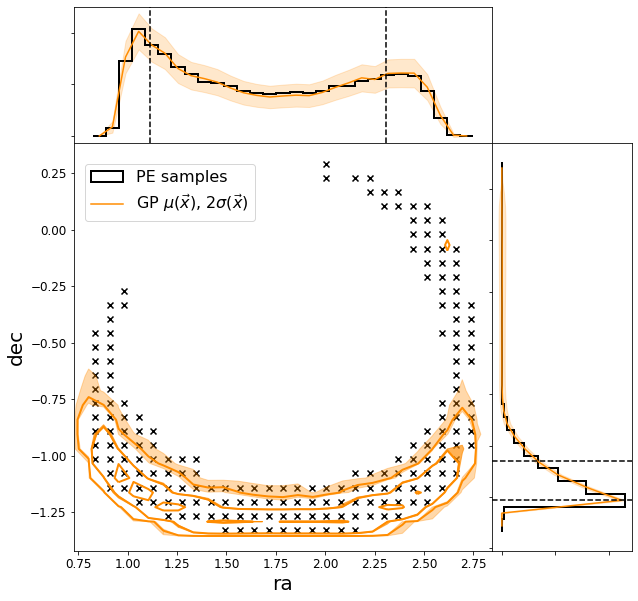

In [39]:
%matplotlib inline
fig, axes = plt.subplots(
    figsize=(10, 10),
    sharex=False,
    sharey=False,
    ncols=2,
    nrows=2,
    gridspec_kw={"width_ratios": [3, 1], "height_ratios": [1, 3]},
)
# labels = [ r'Original PE samples',r'GP samples', r'Bounded KDE samples']

axes[0, 0].hist(
    unscaled_data["ra"],
    density=True,
    histtype="step",
    bins=bin_plot[0],
    linewidth=2,
    label="PE samples",
    color='k',
)
axes[0, 0].plot(
    centroid_calc(bins[0]),
    scaled_ra_mean,
    color='darkorange',
    label=r"GP $\mu(\vec{x})$, $2\sigma(\vec{x})$",
)

axes[0, 0].fill_between(
    centroid_calc(bins[0]),
    upper_var_ra,
    lower_var_ra,
    color='darkorange',
    alpha=0.2,
)

# axes[0, 0].hist(gp_samples[:,0], density=True, histtype='step', bins=bin_plot[0], linewidth=2, label='GP model samples', color=CB_color_cycle[2])

axes[0, 0].set_xticklabels([])
axes[0, 0].set_yticklabels([])
axes[0, 1].axis("off")

axes[1, 0].contour(
    z.T,
    t_contours,
    extent=[bin_array[0, :].min(), bin_array[0, :].max(), bin_array[1, :].min(), bin_array[1, :].max()],
    colors="darkorange",
    linewidths=2,
)

a = axes[1, 0].contour(
    z_high.T,
    t_contours_high,
    extent=[bin_array[0, :].min(), bin_array[0, :].max(), bin_array[1, :].min(), bin_array[1, :].max()],
    colors="red",
    linewidths=0,
)
b = axes[1, 0].contour(
    z_low.T,
    t_contours_low,
    extent=[bin_array[0, :].min(), bin_array[0, :].max(), bin_array[1, :].min(), bin_array[1, :].max()],
    colors="blue",
    linewidths=0,
)
k = 0
for i in range(len(t_contours)):
    j = i + 1
    p = a.collections[i].get_paths()[k]
    v = p.vertices
    xxx = v[:, 0]
    yyy = v[:, 1]

    pp = b.collections[i].get_paths()[k]
    vv = pp.vertices
    xx = vv[:, 0]
    yy = vv[:, 1]

    axes[1, 0].fill(
        np.append(xx, xxx[::-1]),
        np.append(yy, yyy[::-1]),
        alpha=j / 3,
        color="darkorange",
    )

x_nonzero = x[y > 0]
axes[1, 0].scatter(x_nonzero[:, 0], x_nonzero[:, 1], color="k", marker="x")

axes[1, 0].set_xlabel("ra", fontsize=20)
axes[1, 0].set_ylabel("dec", fontsize=20)

axes[1, 1].hist(
    unscaled_data["dec"],
    density=True,
    histtype="step",
    bins=bin_plot[1],
    orientation="horizontal",
    linewidth=2,
    color='k',
)
axes[1, 1].plot(scaled_dec_mean, centroid_calc(bins[1]), color='darkorange')

axes[1, 1].fill_betweenx(
    centroid_calc(bins[1]),
    upper_var_dec,
    lower_var_dec,
    color='darkorange',
    alpha=0.2,
)

axes[1, 1].set_xticklabels([])
axes[1, 1].set_yticklabels([])

axes[0, 0].axvline(
    summary_ra.median - summary_ra.minus, ls="--", color='k'
)
axes[0, 0].axvline(
    summary_ra.median + summary_ra.plus, ls="--", color='k'
)

axes[1, 1].axhline(
    summary_dec.median - summary_dec.minus, ls="--", color='k'
)

axes[1, 1].axhline(
    summary_dec.median + summary_dec.plus, ls="--", color='k'
)

for ax in fig.get_axes():
    ax.tick_params(axis="both", labelsize=12)
plt.subplots_adjust(wspace=0, hspace=0)

handles, labels = axes[0, 0].get_legend_handles_labels()

order = [1, 0]

axes[1, 0].legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    fontsize=16,
    loc="lower center",
    bbox_to_anchor=(0.23, 0.79),
)

# fig.legend(labels, loc='lower center', bbox_to_anchor=(0.45,0.01), ncol=len(labels), bbox_transform=fig.transFigure, fontsize=15)
# plt.savefig("GP_2D_sky_loc.png", dpi=100)

# Extra: re-sample ra and dec with MCMC

In [40]:
%%time
mcmc_points = 3000
num_burnin = mcmc_points * 0.3
num_chains = 2

print(f"mcmc_points: {mcmc_points}, num_burnin: {int(num_burnin)}")
print("Running chain..")
all_samples = bounded_model.sample_density(
    num_results=mcmc_points,
    num_burnin_steps=int(num_burnin),
    initialise_chains=x_scaler.transform(np.array([1.0, -1.168]).reshape(1, -1))
    + 1e-6 * np.random.randn(num_chains, X.shape[1]),
    sampler="MCMC",
)

mcmc_points: 3000, num_burnin: 900
Running chain..
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
Running sampler with TransformedTransitionKernel


/home/virginia.demilio/.conda/envs/gp4gw/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


CPU times: user 42.3 s, sys: 2.12 s, total: 44.4 s
Wall time: 33.9 s


In [41]:
dim = len(param_names)

In [42]:
combine_chains = np.zeros((mcmc_points * num_chains, dim))
for i in range(dim):
    combine_chains[:, i] = all_samples[:, :, i].numpy().flatten()
gp_samples = x_scaler.inverse_transform(combine_chains)

az_data = convert_to_arviz_data(all_samples, x_scaler, param_names)

az.summary(az_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ra,1.691,0.558,0.927,2.566,0.034,0.024,259.0,364.0,1.01
dec,-1.168,0.137,-1.321,-0.989,0.011,0.007,610.0,366.0,1.00


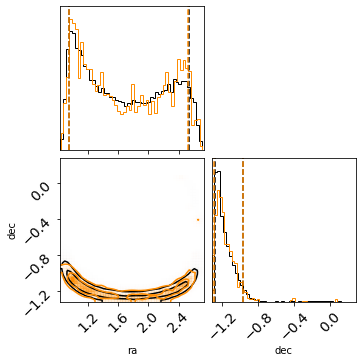

In [43]:
%matplotlib inline
fig1 = corner.corner(
    unscaled_data[param_names],
    bins=50,
    plot_datapoints=False,
    labels=param_names,
    color="k",
    smooth=0.9,
    levels=[
        0.5,
        0.9,
    ],
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
)

fig = corner.corner(
    gp_samples,
    fig=fig1,
    bins=50,
    plot_datapoints=False,
    labels=param_names,
    color="darkorange",
    smooth=0.9,
    levels=[
        0.5,
        0.9,
    ],
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
)

for ax in fig.get_axes():
    ax.tick_params(axis="both", labelsize=14)